<div style="text-align:center"><h1>Running Coupling Constant</h1></div>
<h2 style="text-align:center">-Various $M_t$</h2>
<div style="text-align:right"><b>Tae Geun Kim</b></div>
*****

## 1. Main Code

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
%load_ext Cython

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn

In [3]:
%%cython
import numpy as np
cimport numpy as np
from math import sqrt, exp, log, log10, pi

cdef class RGE:
    cdef public object t, mt, xi, Mp, MpR, MW, MZ, MH, alphasMZ, lH, yt, g1, g2, g3
    cdef object h, sh, Beta_lH1, Beta_g11, Beta_g21, Beta_g31, Beta_yt1, gamma1
    cdef object Beta_lH2, Beta_g12, Beta_g22, Beta_g32, Beta_yt2, gamma2, Betas1, Betas2
    cdef object Beta, Beta_real
    
    def __init__(self, mt_init, xi_init, tstart):
        self.t = tstart
        self.mt = mt_init
        self.xi = xi_init
        self.Mp = 1.221*10**(19)
        self.MpR = 2.4*10**(18) # Reduced Planck Mass
        self.MW = 80.385
        self.MZ = 91.1876
        self.MH = 125.09
        self.alphasMZ = 0.1182
        self.lH = 0.12604 + 0.00206 * (self.MH - 125.15) - 0.00004 * (self.mt - 173.34)
        self.yt = (
            0.93690 + 0.00556 * (self.mt - 173.34) - 0.00003*(self.MH - 125.15) 
            - 0.00042*(self.alphasMZ - 0.1184) / 0.0007
        )
        self.g3 = 1.1666 + 0.00314 * (self.alphasMZ - 0.1184)/0.007 - 0.00046 * (self.mt - 173.34)
        self.g2 = 0.64779 + 0.00004 * (self.mt - 173.34) + 0.00011 * (self.MW - 80.384) / 0.014
        self.g1 = 0.35830 + 0.00011 * (self.mt - 173.34) - 0.00020 * (self.MW - 80.384) / 0.014
               
    def BETA(self):
        # 1-Loop Beta Functions
        self.h = sqrt(2)/self.yt * self.mt * exp(self.t)
        self.sh = (
            (1 + self.xi * self.h ** 2 / self.MpR**2)/(1+(1+6*self.xi)*self.xi*self.h**2/self.MpR**2)
        )
        self.Beta_lH1 = (
            6*(1+3*self.sh**2)*self.lH**2 + 12*self.lH*self.yt**2 - 6*self.yt**4 - 3*self.lH*(3*self.g2**2 + self.g1**2)
            + 3/8*(2*self.g2**4 + (self.g1**2 + self.g2**2)**2)
        )
        self.Beta_g11 = (81 + self.sh)/12 * self.g1**3
        self.Beta_g21 = - (39 - self.sh) / 12 * self.g2 **3
        self.Beta_g31 = -7*self.g3**3
        self.Beta_yt1 = (
            self.yt * ((23/6 + 2/3*self.sh)*self.yt**2 - (8*self.g3**2 + 9/4*self.g2**2 + 17/12 * self.g1**2))
        )
        self.gamma1 = -(9/4*self.g2**2 + 3/4*self.g1**2 - 3*self.yt**2)
        self.Betas1 = [self.Beta_lH1, self.Beta_g11, self.Beta_g21, 
                       self.Beta_g31, self.Beta_yt1, self.gamma1]
        # 2-Loop Beta Functions
        self.Beta_lH2 = (
            1/48*((912+3*self.sh)*self.g2**6 - (290-self.sh)*self.g1**2*self.g2**4 
                  - (560-self.sh) * self.g1**4*self.g2**2 - (380-self.sh)*self.g1**6)
            + (38-8*self.sh)*self.yt**6 - self.yt**4 * (8/3*self.g1**2 + 32*self.g3**2 + (12-117*self.sh+108*self.sh**2)*self.lH)
            + self.lH * (-1/8*(181 + 54*self.sh - self.sh**2)*self.g2**4
                        + 1/4*(3-18*self.sh + 54*self.sh**2)*self.g1**2*self.g2**2 + 1/24*(90+377*self.sh+162*self.sh**2)*self.g1**4
                        + (27+54*self.sh+27*self.sh**2)*self.g2**2*self.lH + (9+18*self.sh+9*self.sh**2)*self.g1**2*self.lH
                        - (48+288*self.sh - 324*self.sh**2 + 624*self.sh**3 - 324*self.sh**4)*self.lH**2)
            + self.yt**2*(-9/4*self.g2**4 + 21/2*self.g1**2*self.g2**2 - 19/4*self.g1**4
                         + self.lH*(45/2*self.g2**2 + 85/6*self.g1**2 + 80*self.g3**2 - (36+108*self.sh**2)*self.lH))
        )
        self.Beta_g12 = (
            199/18 * self.g1**5 + 9/2 * self.g1**3*self.g2**2 + 44/3*self.g1**3*self.g3**2
            - 17/6 * self.sh * self.g1**3 * self.yt**2
        )
        self.Beta_g22 = (
            3/2 * self.g1**2 * self.g2**3 + 35/6*self.g2**5 + 12*self.g2**3*self.g3**2
            - 3/2 * self.sh * self.g2**3 * self.yt**2
        )
        self.Beta_g32 = (
            11/6 * self.g1**2 * self.g3**3 + 9/2*self.g2**2*self.g3**3 - 26*self.g3**5
            - 2 * self.sh * self.g3**3 * self.yt**2
        )
        self.Beta_yt2 = (
            self.yt * (-23/4 * self.g2**4 - 3/4 * self.g1**2 * self.g2**2 + 1187/216*self.g1**4
                      + 9*self.g2**2*self.g3**2 + 19/9*self.g1**2*self.g3**2 - 108*self.g3**4
                      + (225/16*self.g2**2 + 131/16*self.g1**2 + 36*self.g3**2)*self.sh*self.yt**2
                      + 6*(-2*self.sh**2*self.yt**4 - 2*self.sh**3*self.yt**2*self.lH + self.sh**2*self.lH**2)
                      )
        )
        self.gamma2 = (
            -(271/32 * self.g2**4 - 9/16 * self.g1**2 * self.g2**2 - 431/96 * self.sh * self.g1**4
             - 5/2 * (9/4 * self.g2**2 + 17/12 * self.g1**2 + 8*self.g3**2) * self.yt**2 + 27/4 * self.sh*self.yt**4
             - 6 * self.sh**3 * self.lH**2)
        )
        self.Betas2 = [self.Beta_lH2, self.Beta_g12, self.Beta_g22, 
                       self.Beta_g32, self.Beta_yt2, self.gamma2]
        # Total Beta Functions
        self.Beta = np.zeros(len(self.Betas1))
        for i, (beta1, beta2) in enumerate(zip(self.Betas1, self.Betas2)):
            self.Beta[i] = 1/(16*pi**2)*beta1 + 1/(16*pi**2)**2*beta2
        self.Beta_real = [beta/(1+self.Beta[5]) for beta in self.Beta]
        
    def Running(self, double h):
        # Running Coupling Constant
        self.lH += h * self.Beta_real[0]
        self.g1 += h * self.Beta_real[1]
        self.g2 += h * self.Beta_real[2]
        self.g3 += h * self.Beta_real[3]
        self.yt += h * self.Beta_real[4]
        self.t += h
#-----------------------------------------------
def RCC(double Mt, double xi, int Nend, double h): # M_t, xi, End point, precision
    # Real Running
    cdef int i, k
    A = RGE(Mt, xi, 0)
    k = int(1/h * Nend)
    cdef np.ndarray[dtype=double, ndim=1] lH, yt, t, g1, g2, g3
    lH = np.empty(k)
    yt = np.empty(k)
    t = np.empty(k)
    g1 = np.empty(k)
    g2 = np.empty(k)
    g3 = np.empty(k)
    for i in range(k):
        A.BETA() # initialize by calling BETA
        lH[i] = A.lH
        g1[i] = A.g1
        g2[i] = A.g2
        g3[i] = A.g3
        yt[i] = A.yt
        t[i] = A.t
        A.Running(h)
    return (lH, g1, g2, g3, yt, t)

## 2. Running Coupling Constants 

### 1) Data Processing

#### - Running

In [5]:
#print('Calculating 170.00...')
#Temp = RCC(170, 1000, 40, 1e-05)
#print('Complete!')

In [6]:
#mt_keys = np.arange(170.851, 170.86, 0.001)
#xi_keys = np.arange(10, 100, 10)
#for mt in mt_keys:
#    for xi in xi_keys:
#        locals()['Temp_'+str(mt)+'_'+str(xi)] = RCC(mt, xi, 40, 1e-05)
#        wrt_temp = open(str(mt)+'_'+str(xi)+'_lamb.csv', 'w')
#        for k, obj in enumerate(locals()['Temp_'+str(mt)+'_'+str(xi)]):
#            for i, elem in enumerate(obj):
#                if i < len(obj):
#                    wrt_temp.write(str(elem)+',')
#                else:
#                    wrt_temp.write(str(elem))
#            wrt_temp.write('\n')
#        wrt_temp.close()

#### - Save Data

In [7]:
## Save
#wrt_temp = open('170.849_1000_lamb.csv', 'w')
#for k, obj in enumerate(Temp):
#    for i, elem in enumerate(obj):
#        if i < len(obj):
#            wrt_temp.write(str(elem)+',')
#        else:
#            wrt_temp.write(str(elem))
#    wrt_temp.write('\n')
#wrt_temp.close()

#Save2
#wrt_temp2 = open('17085_59_lamb.csv', 'w')
#for k, obj in enumerate(Temp2):
#    for i, elem in enumerate(obj):
#        if i < len(obj):
#            wrt_temp2.write(str(elem)+',')
#        else:
#            wrt_temp2.write(str(elem))
#    wrt_temp2.write('\n')
#wrt_temp2.close()

#### - Import Data

In [5]:
# Read
mt_keys = np.arange(170.84, 170.852, 0.001)
for mt in mt_keys:
    in_temp = open(str(mt)+'_50_lamb.csv', 'r')
    TP = [line.split(',') for line in in_temp]
    for obj in TP:
        del(obj[len(obj)-1])
    locals()['lH_'+str(mt)] = [float(elem) for elem in TP[0]]
    locals()['g1_'+str(mt)] = [float(elem) for elem in TP[1]]
    locals()['g2_'+str(mt)] = [float(elem) for elem in TP[2]]
    locals()['g3_'+str(mt)] = [float(elem) for elem in TP[3]]
    locals()['yt_'+str(mt)] = [float(elem) for elem in TP[4]]
    locals()['t_'+str(mt)] = [float(elem) for elem in TP[5]]

#### - Use LaTeX

In [6]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### 2) Running $\lambda\,$ ($\xi = 50$)

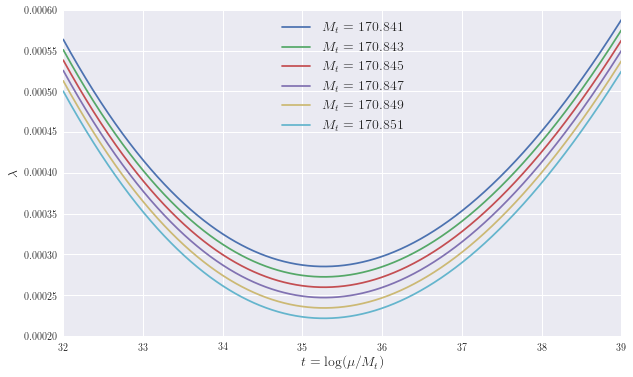

In [18]:
mt_keys = np.arange(170.841, 170.852, 0.002)
plt.figure(figsize=(10,6))
for mt in mt_keys:
    plt.plot(locals()['t_'+str(mt)], locals()['lH_'+str(mt)], label=r'$M_t='+str(mt)+'$')
plt.xlabel(r'$t=\log(\mu/M_t)$', fontsize=14)
plt.ylabel(r'$\lambda$', fontsize=14)
plt.axis([32, 39, 0.0002, 0.0006])
plt.legend(fontsize=14)
plt.show()